In [1]:

import os ; import sys
sys.path.append(os.environ["DMRGROOT"]) # add the library via environmental variable
# you have to install the dmrgpy library from
# https://github.com/joselado/dmrgpy
# and add its address to your python path (done above with an environmental variable)

# some default parameters in matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'


import numpy as np

# Quantum magnetism

### Learning outcomes
- Understand the structure of a quantum many-body Hamiltonian
- Rationalize level crossing in many-body systems
- Understand the meaning of static correlators in many-body systems



## Basics
Here you can learn the basics of the code that you will use

### Creating a spin_chain object
This is the most important object, it is an abstract object that contains your physical system and will allow you to compute all the quantities

In [2]:
from dmrgpy import spinchain
spins = ["S=1" for i in range(6)] # create a chain with 6 spins 1
sc = spinchain.Spin_Chain(spins) # create the spin chain object

In [3]:
from dmrgpy import spinchain
spins = ["S=1" for i in range(4)] + ["S=1/2" for i in range(2)] # first four spins 1, then two spin 1/2
sc = spinchain.Spin_Chain(spins) # create the spin chain object

In [4]:
from dmrgpy import spinchain
spins = ["S=1/2" for i in range(2)] # or just a dimer with S=1/2
sc = spinchain.Spin_Chain(spins) # create the spin chain object

### Creating a Hamiltonian
You can write a many-body Hamiltonian directly with the many-body spin operators

In [5]:
H_I = sc.Sz[0]*sc.Sz[1] # this would be an Ising Hamiltonian
H_XY = sc.Sx[0]*sc.Sx[1] + sc.Sy[0]*sc.Sy[1] # this would be an XY Hamiltonian
H_Hei = sc.Sx[0]*sc.Sx[1] + sc.Sy[0]*sc.Sy[1] + sc.Sz[0]*sc.Sz[1] # this would be a Heisenberg Hamiltonian

### Computing the ground state energy
Once you have computed a Hamiltonian, you can obtain the ground state energy by setting the Hamiltonian in the spin chain object and executing a bound method 

In [6]:
sc.set_hamiltonian(H_I) # set the Hamiltonian
E0_I = sc.gs_energy(mode="ED") # compute the energy for the Ising model

sc.set_hamiltonian(H_XY) # set the Hamiltonian
E0_XY = sc.gs_energy(mode="ED") # compute the energy for the Ising model

sc.set_hamiltonian(H_Hei) # set the Hamiltonian
E0_Hei = sc.gs_energy(mode="ED") # compute the energy for the Ising model
print("Energy of the Ising model",E0_I)
print("Energy of the XY model",E0_XY)
print("Energy of the Heisenberg model",E0_Hei)

Energy of the Ising model -0.25
Energy of the XY model -0.5
Energy of the Heisenberg model -0.75


#### Quiz
- Show analytically that the energy of the ground states is the result obtained above
- Why is the energy of the Heisenberg model the sum of the Ising and XY models?
- If you had more than two spins coupled, will it still be the case?

### Computing expectation values
Apart from the ground state energy, we may want to compute observables associated to ground state. This can be done either by using the built in algegra and compute overlaps, or by a bound method

In [7]:
from dmrgpy import spinchain
spins = ["S=1/2" for i in range(4)] # four spins with S=1/2
sc = spinchain.Spin_Chain(spins) # create the spin chain object
H = 0 # initialize Hamiltonian
for i in range(len(spins)-1): # nearest neighbor Heisenberg coupling
    H = H + sc.Sx[i]*sc.Sx[i+1] ; H = H + sc.Sy[i]*sc.Sy[i+1] ; H = H + sc.Sz[i]*sc.Sz[i+1]

sc.set_hamiltonian(H) # set the Hamiltonian
GS = sc.get_gs() # compute the ground state

Op = sc.Sx[0]*sc.Sx[1] # correlator between first and second sites

wOw0 = GS.dot(Op*GS).real # compute the expectation value with the braket < GS | Op | GS >
wOw1 = sc.vev(Op).real # compute the expectation value with the built in method

print("Correlator with the braket",wOw0)
print("Correlator with the built in method",wOw1)

Correlator with the braket -0.22767090063077658
Correlator with the built in method -0.22767090063077677


#### Quiz
- Replace Sx by Sy in the operator to compute the expectation value (Op). What happens, and why
- If you had an XY model instead of the Heisenebrg model, what would happen, and why?

## Many-body energies of the Heisenberg model
Let us first look at the many-body spectrum of a Heisenberg model

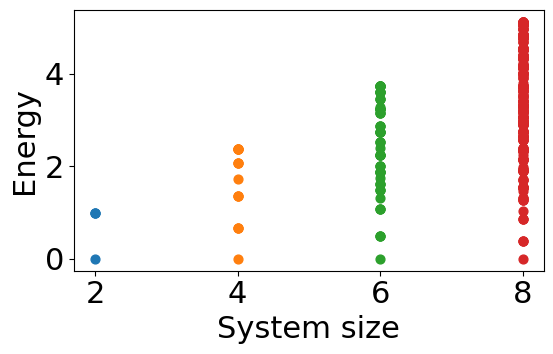

In [8]:
from dmrgpy import spinchain

def get_energies(N):
    """Return energies for a system fo size N"""
    spins = ["S=1/2" for i in range(N)] # S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = 1. # exchange coupling
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h)
    return sc.get_excited(mode="ED",n=300)

plt.figure(figsize=(6,4))

for N in [2,4,6,8]: # loop over system sizes
    es = get_energies(N) # many-body energies for a system of size N
    es = es-es[0] # set reference in the ground state
    plt.scatter(es*0 + N,es,s=40) # plot the energies

plt.xlabel("System size") ; plt.ylabel("Energy") ;  plt.tight_layout()

### Quiz
- Why is the number of energies increasing with the system size
- How does the number of energies depend on the system size
- Plot only the difference between the two lowest states, what do you observe?
- What is the biggest system for which you could store all the energies in your computer?

## From classical to quantum magnetism
Let us first see how the spectrum of a Hamiltonian evolves from the classical to the quantum limit

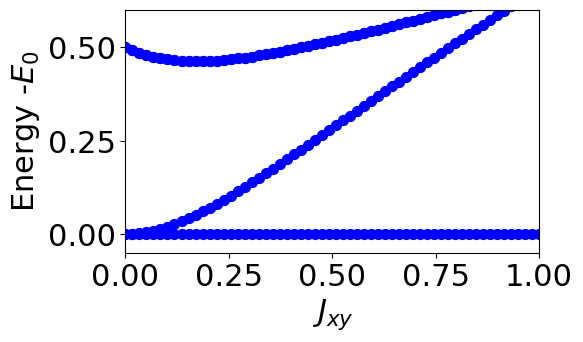

In [15]:
from dmrgpy import spinchain

def get_energies(Jxy,N=4):
    """Return energies for a system fo size N"""
    spins = ["S=1/2" for i in range(N)] # N S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + Jxy*sc.Sx[i]*sc.Sx[i+1] ; h = h + Jxy*sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
#    for i in range(len(spins)): h = h + Bz*sc.Sz[i] # and lets add a small magnetic field
    sc.set_hamiltonian(h) # set the Hamiltonian
    return sc.get_excited(mode="ED",n=4) # compute excited states

Jxys = np.linspace(0.,1.,60)

plt.figure(figsize=(6,4))

for Jxy in Jxys: # loop over magnetic fields
    es = get_energies(Jxy) # many-body energies for a system of size N
    es = es -es[0]# set reference in the ground state
    plt.scatter(es*0 + Jxy,es,s=50,c="blue") # plot the energies

plt.xlabel("$J_{xy}$") ; plt.ylabel("Energy -$E_0$") ; plt.xlim([min(Jxys),max(Jxys)]) 
plt.ylim([-0.05,0.6]) ; plt.tight_layout()

### Quiz
- Make the system bigger, what happens and why?

## Energies of a Heisenberg model as a function of the external magnetic field
We will now look at the evolution of the energy of the Heisenberg model as a function of the external magnetic field in order to understand the internal structure of the many-body states

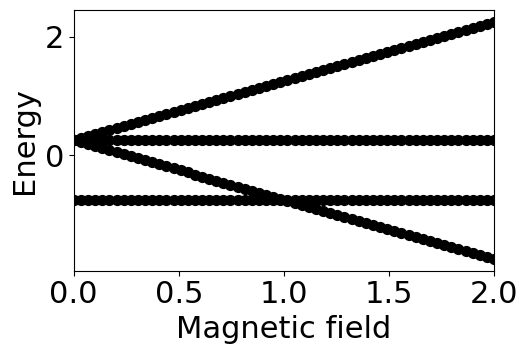

In [11]:
from dmrgpy import spinchain

def get_energies(Bz):
    """Return energies for a system fo size N"""
    spins = ["S=1/2" for i in range(2)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    for i in range(len(spins)): h = h + Bz*sc.Sz[i] # and lets add a small magnetic field
    sc.set_hamiltonian(h) # set the Hamiltonian
    return sc.get_excited(mode="ED",n=300) # compute up to 300 excited states

Bzs = np.linspace(0.,2.,60)

plt.figure(figsize=(6,4))

for Bz in Bzs: # loop over magnetic fields
    es = get_energies(Bz) # many-body energies for a system of size N
    es = es # set reference in the ground state
    plt.scatter(es*0 + Bz,es,s=50,c="black") # plot the energies

plt.xlabel("Magnetic field") ; plt.ylabel("Energy") ; plt.xlim([min(Bzs),max(Bzs)]) ; plt.tight_layout()

### Quiz
- Why do the eigenvalues evolve linearly with the external magnetic field?
- What happens at magnetic field equal to 1, and what its the physical consequence?
- Which term would you need to add to the Hamiltonian so that the evolution is non-linear, and why?
- What happens if you increase the system size to N=3, how does the lowest energy state change and why?

## Quantum numbers in the Heisenberg model
We will now see how in the Heisenebrg model the quantum number conservation can be directly seen from the spectra

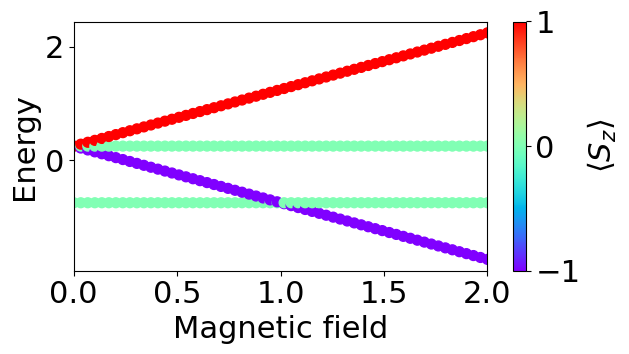

In [11]:
from dmrgpy import spinchain

N = 2 # number of sites

def get_energies_mzs(Bz):
    """Return energies for a system fo size N"""
    spins = ["S=1/2" for i in range(N)] # spin chain
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    for i in range(len(spins)): h = h + Bz*sc.Sz[i] # and lets add a small magnetic field
    sc.set_hamiltonian(h) # set the Hamiltonian
    es,wfs = sc.get_excited_states(mode="ED",n=300) # compute up to 300 excited states
    cs = [wf.dot(sum(sc.Sz)*wf) for wf in wfs] # expectation value of the magnetization
    return es,cs

Bzs = np.linspace(0.,2.,60)

plt.figure(figsize=(7,4))

for Bz in Bzs: # loop over magnetic fields
    es,cs = get_energies_mzs(Bz) # many-body energies for a system of size N
    plt.scatter(es*0 + Bz,es,s=50,c=cs,cmap="rainbow",vmin=-N/2,vmax=N/2) # plot the energies

plt.colorbar(label="$\\langle S_z \\rangle $",ticks=[-N/2,0,N/2])
plt.xlabel("Magnetic field") ; plt.ylabel("Energy") ; plt.xlim([min(Bzs),max(Bzs)]) ; plt.tight_layout()

### Quiz
- Can you identify which line corresponds to which many body wavefunction?
- What is the difference between the two flat lines?
- Make the system bigger, what happens and why?

## Level crossings in the Heisenberg model
Let now look how the ground state changes as a function of the external magnetic field

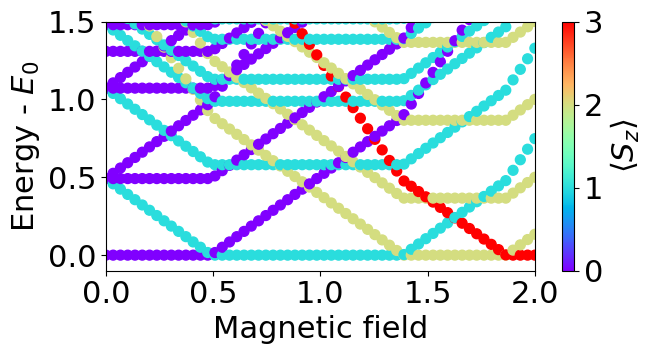

In [12]:
from dmrgpy import spinchain

def get_energies_mzs(Bz):
    """Return energies for a system fo size N"""
    N = 6 # number of sites
    spins = ["S=1/2" for i in range(N)] # spin chain
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    for i in range(len(spins)): h = h - Bz*sc.Sz[i] # and lets add a small magnetic field
    sc.set_hamiltonian(h) # set the Hamiltonian
    nex = 20 # number of excited states
    es,wfs = sc.get_excited_states(mode="ED",n=nex) # compute up to 300 excited states
    cs = [wf.dot(sum(sc.Sz)*wf).real for wf in wfs] # expectation value of the magnetization
#    print(es-es[0],cs)
    return es-es[0],cs

Bzs = np.linspace(0.,2.,60)

plt.figure(figsize=(7,4))

for Bz in Bzs: # loop over magnetic fields
    es,cs = get_energies_mzs(Bz) # many-body energies for a system of size N
    plt.scatter(es*0 + Bz,es,s=50,c=cs,cmap="rainbow",vmin=0,vmax=3) # plot the energies

plt.colorbar(label="$\\langle S_z \\rangle $")
plt.xlabel("Magnetic field") ; plt.ylabel("Energy - $E_0$") 
plt.xlim([min(Bzs),max(Bzs)]) ; plt.ylim([-0.1,1.5]) ; plt.tight_layout()

### Quiz
- At which values of magnetic field does the ground state change?
- Make the system smaller, what do you observe and why?
- Make the system bigger, what do you observe and why?

## Many-body wavefunctions in a magnetic field
We will now look at the magnetization of different states in the presence of a small magnetic field

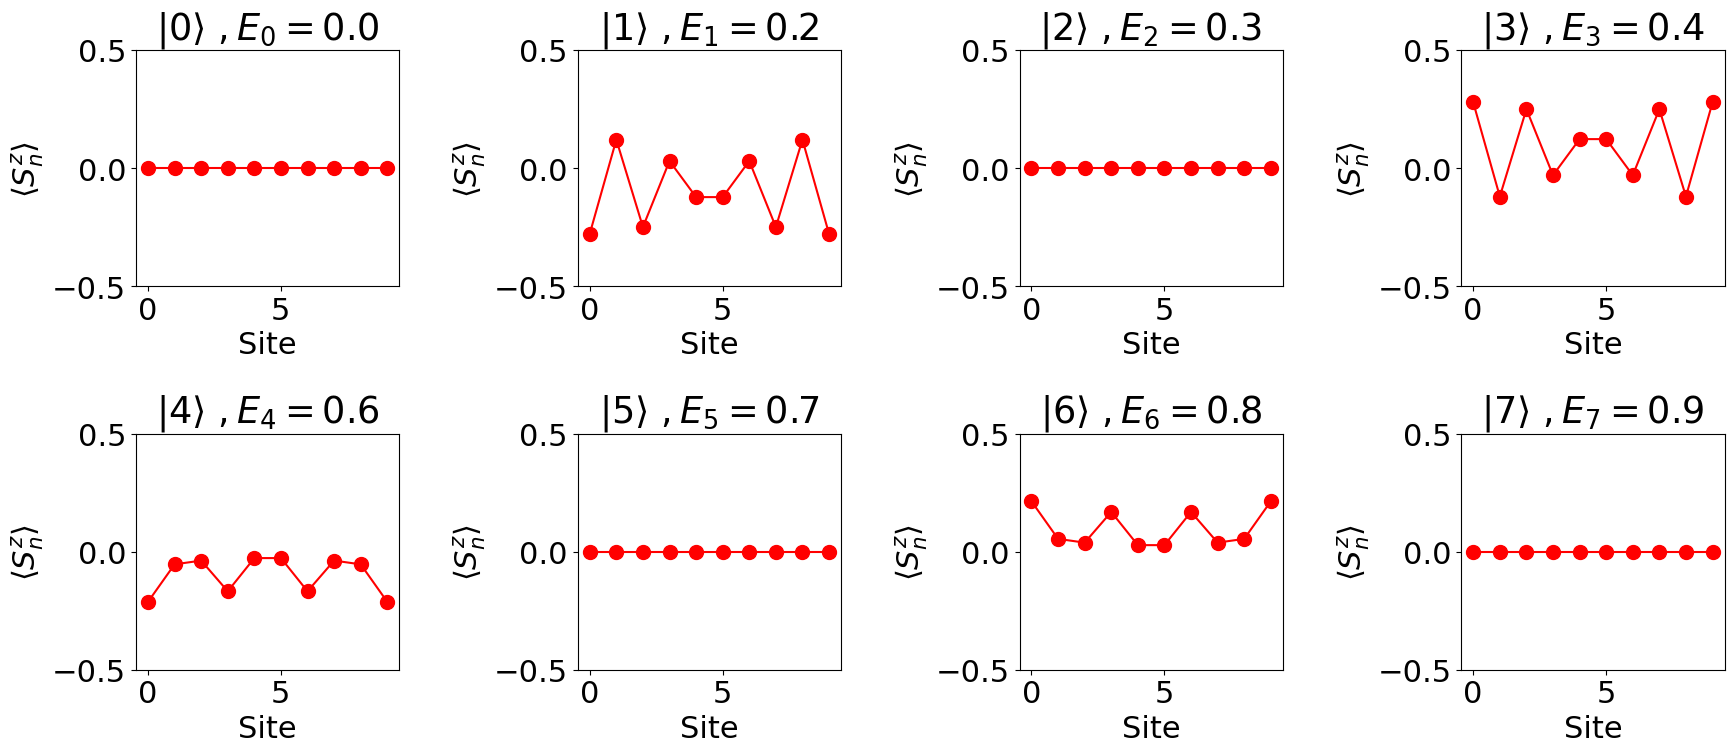

In [13]:
from dmrgpy import spinchain

L = 10 # number of spins

spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1): # Heisenberg coupling
    h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
Bz = 0.1 # small magnetic field
h = h + Bz*sum(sc.Sz) # add external field
sc.set_hamiltonian(h) # set the Hamiltonian
nex = 8 # number of excited states
es,wfs = sc.get_excited_states(n=nex,mode="ED") # compute energies and excited states
es = es - es[0] # energy with respect to the ground state

plt.figure(figsize=(18,8))
ii = 1 # counter
for (e,wf) in zip(es,wfs): # loop
    plt.subplot(2,nex//2,ii) ; ii +=1 # subplot and increase
    mzs = [wf.dot(sz*wf) for sz in sc.Sz] # magnetization
    plt.plot(range(len(mzs)),mzs,marker="o",markersize=10,c="red") # plot
    plt.ylim([-0.5,0.5]) ; plt.ylabel("$\\langle S^z_n \\rangle$") ; plt.xlabel("Site")
    plt.title("$|$"+str(ii-2) + "$\\rangle$ $, E_"+str(ii-2)+" = $"+str(np.round(e,1)))
plt.tight_layout()

## Level crossings as a function of the magnetic field
We will now show that as an external magnetic field is included, level crossings in the system take place leading to different ground states

Text(0, 0.5, '$B_z$')

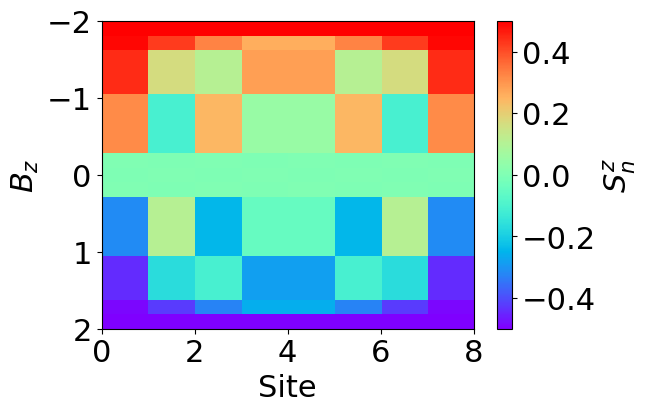

In [14]:
from dmrgpy import spinchain

L = 8 # number of spins

def get_mz(Bz):
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    h = h + Bz*sum(sc.Sz) # add external field
    sc.set_hamiltonian(h) # set the Hamiltonian
    wf0 = sc.get_gs(mode="ED")
    return [wf0.dot(Szi*wf0).real for Szi in sc.Sz] # magnetization in each site



Bzs = np.linspace(-2.,2.,21,endpoint=True) # magnetic fields
Mzs = [get_mz(Bz) for Bz in Bzs] # compute magnetizations

plt.figure(figsize=(6,4))

plt.imshow(Mzs,aspect="auto",extent=[0,L,max(Bzs),min(Bzs)],vmin=-0.5,vmax=0.5,cmap="rainbow")
plt.colorbar(label="$S^z_n$") ; plt.xlabel("Site") ; plt.ylabel("$B_z$")

### Quiz
- Why does the magnetization saturate at high magnetic fields?
- Make the system smaller, what do you observe and why?

## Magnetization of moderately large Heisenberg model
Here we will show that a moderately large quantum Heisenberg model has zero magnetization

(0.0, 9.0)

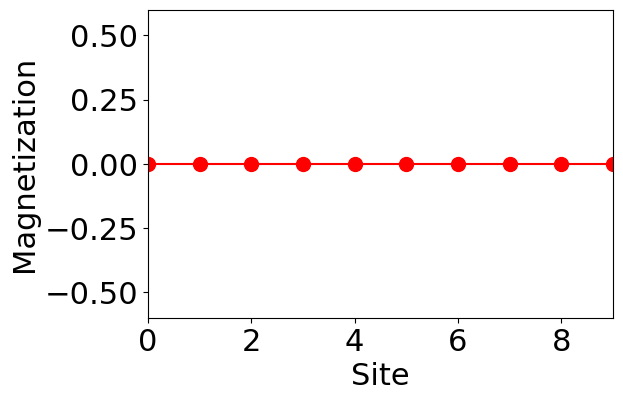

In [15]:
from dmrgpy import spinchain
n = 10 # number of sites
spins = ["S=1/2" for i in range(n)] # S=1/2 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
J = 1.0 # antiferromagnetic coupling, J=-1 for ferromagnetic coupling
Bz = -0.01 # small external magnetic field

for i in range(len(spins)-1): # Heisenber coupling
    h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    
for i in range(len(spins)): h = h + Bz*sc.Sz[i] # and lets add a small magnetic field
    
sc.set_hamiltonian(h) # set the Hamiltonian
iis = range(n)
cs = [sc.vev(sc.Sz[i]) for i in iis] # compute the vacuum expectation value

plt.figure(figsize=(6,4))

plt.plot(iis,cs,marker="o",c="red",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- Why is the magnetization zero everywhere even though there is a small external magnetic field?
- Make the value of the exchange negative, what happens and why?
- Take the case with antiferromagnetic coupling, and increase the value of the magnetic field. When do you get a finite magnetization and why?

## Gap of a many-body spin chain
We will now see how the gap for a many-body spin chain scales with the system size, both for a pristine Heisenberg model and a dimerized one

(2.0, 14.0)

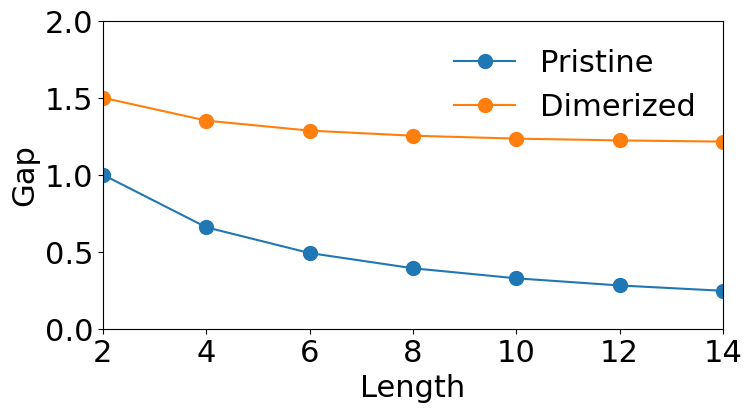

In [16]:
from dmrgpy import spinchain

def get_gap(n=10,dJ=0.):
    spins = ["S=1/2" for i in range(n)] # S=1 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1):
        J = 1.0 + dJ*(-1)**i
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h) # create the Hamiltonian
    es = sc.get_excited(n=2,mode="ED") # get excited state energies
    g = es[1]-es[0] # energy to the first excited state
    return g # return the many-body gap

Ls = range(2,16,2) # lengths of the system to consider
gaps = [get_gap(n=L,dJ=0.) for L in Ls] # gaps for the Heisenberg model
gaps_dim = [get_gap(n=L,dJ=0.5) for L in Ls] # gaps for the dimerized Heisenberg model

plt.figure(figsize=(8,4))
plt.plot(Ls,gaps,label="Pristine",marker="o",markersize=10)
plt.plot(Ls,gaps_dim,label="Dimerized",marker="o",markersize=10)
plt.legend(frameon=False)
plt.xlabel("Length") ; plt.ylabel("Gap") ; plt.ylim([0.,2.0]) ; plt.xlim([2,max(Ls)])

## Magnetization of a Heisenberg model with a magnetic impurity
Here we will now add a magnetic impurity to a quantum Heisenberg model, and see how the magnetization decays with distance

(0.0, 13.0)

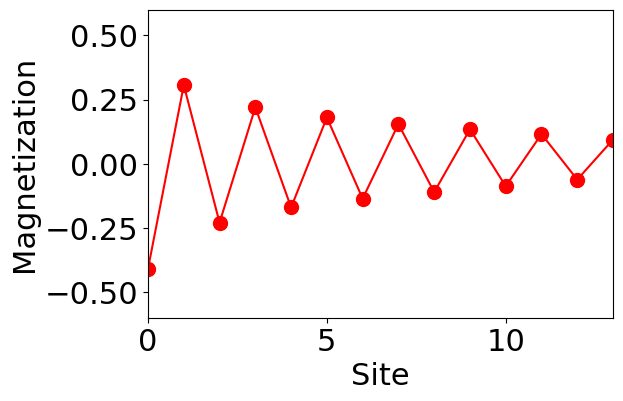

In [17]:
from dmrgpy import spinchain
n = 14 # length of the system
spins = ["S=1/2" for i in range(n)] # S=1 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1):
    h = h + sc.Sx[i]*sc.Sx[i+1]
    h = h + sc.Sy[i]*sc.Sy[i+1]
    h = h + sc.Sz[i]*sc.Sz[i+1]

    
Bz = 1. # local magnetization
h = h + Bz*sc.Sz[0]
    
sc.set_hamiltonian(h) # create the Hamiltonian
iis = range(n)
cs = [sc.vev(sc.Sz[i]) for i in iis]

plt.figure(figsize=(6,4))

plt.plot(iis,cs,marker="o",c="red",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- Why does the magnetization decay away from the magnetic site?

## Magnetization of a dimerized Heisenberg model with a magnetic impurity
Here we will now add a magnetic impurity to a dimerized quantum Heisenberg model, and see how the magnetization decays with distance

(0.0, 13.0)

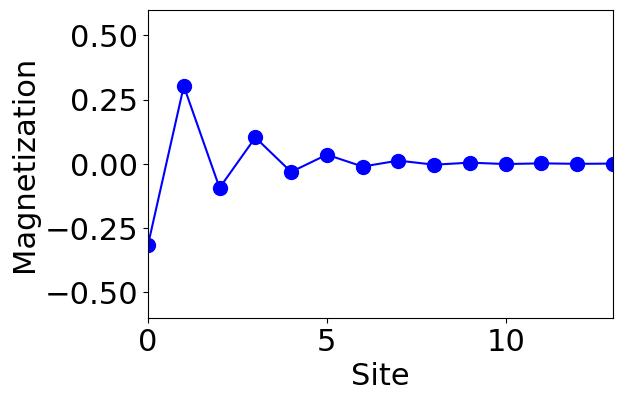

In [18]:
from dmrgpy import spinchain
n = 14 # length of the system
spins = ["S=1/2" for i in range(n)] # S=1 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1):
    J = 1.0 + .3*(-1)**i
    h = h + J*sc.Sx[i]*sc.Sx[i+1]
    h = h + J*sc.Sy[i]*sc.Sy[i+1]
    h = h + J*sc.Sz[i]*sc.Sz[i+1]

    
Bz = 1. # local magnetization
h = h + Bz*sc.Sz[0]
    
sc.set_hamiltonian(h) # create the Hamiltonian
iis = range(n)
cs = [sc.vev(sc.Sz[i]) for i in iis]

plt.figure(figsize=(6,4))

plt.plot(iis,cs,marker="o",c="blue",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- Why is the local magnetization decreasing?
- Why is the decrease much faster than the case above?

## Non-local static correlators
We will now see how the non-local static correlators allow infering which system has the strongest gap

Text(0, 0.5, '$\\langle S_0^x S_N^x \\rangle $')

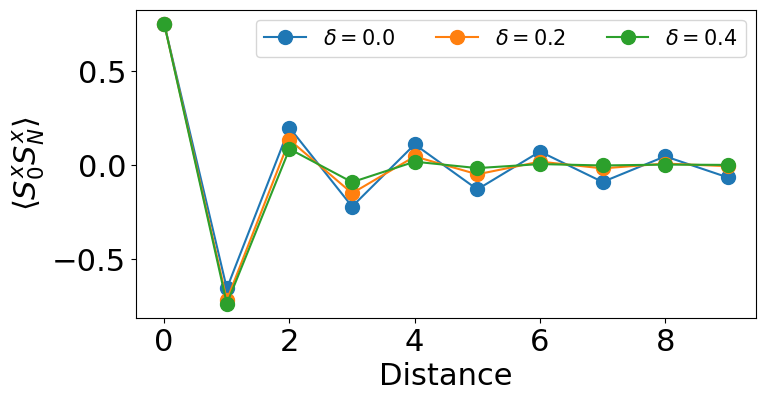

In [19]:
from dmrgpy import spinchain

def get_correlator(n=10,dJ=0.):
    spins = ["S=1/2" for i in range(n)] # S=1 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1):
        J = 1.0 + dJ*(-1)**i
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h) # create the Hamiltonian
    wf0 = sc.get_gs() # compute ground state
    return [3*wf0.dot(sc.Sx[0]*sc.Sx[i]*wf0).real for i in range(n)]

plt.figure(figsize=(8,4))

dJs = [0.,0.2,0.4] # dimerizations
for dJ in dJs:
    cij = get_correlator(n=10,dJ=dJ)
    plt.plot(range(len(cij)),cij,label="$\\delta =$"+str(dJ),marker="o",markersize=10)

plt.legend(ncol=len(dJs),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle S_0^x S_N^x \\rangle $") #; plt.ylim([0.,2.0]) ; plt.xlim([2,max(Ls)])

### Quiz
- Which parameter would lead to the biggest gap in the thermodynamic limit
- Make the system bigger, what do you observe?
- How can you know if some of the systems will be gapless in the thermodynamic limit?

## Dynamical correlators
Let us now look at the dynamical correlator of a Heisenberg model

([<matplotlib.axis.XTick at 0x768e9c59ba10>,
 [Text(0, 0, '0'), Text(9, 0, '9')])

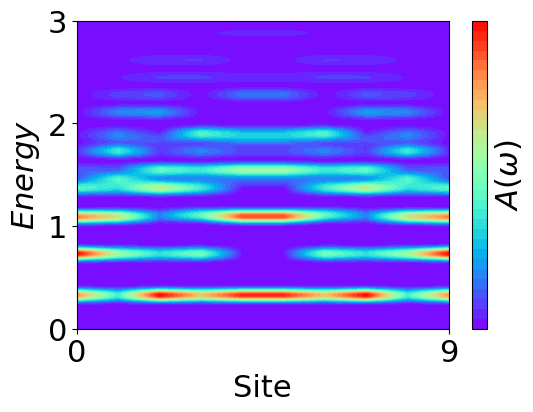

In [20]:
from dmrgpy import spinchain
n = 10 # length of the system
spins = ["S=1/2" for i in range(n)] # S=1 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1):
    J = 1.0 
    h = h + J*sc.Sx[i]*sc.Sx[i+1]
    h = h + J*sc.Sy[i]*sc.Sy[i+1]
    h = h + J*sc.Sz[i]*sc.Sz[i+1]

sc.set_hamiltonian(h) # create the Hamiltonian

es = np.linspace(-0.,3,300)
dyn = [sc.get_dynamical_correlator(name=(sc.Sz[i],sc.Sz[i]),mode="ED",es=es)[1].real for i in range(n)]

plt.figure(figsize=(6,4))
plt.contourf(range(n),es,np.array(dyn).T,aspect="auto",levels=30,cmap="rainbow")
plt.colorbar(label="$A(\omega)$",ticks=[]) ; plt.xlabel("Site") ; plt.ylabel("$Energy$") ; plt.xticks([0,n-1])

### Quiz
- Make the system smaller, what do you observe and why?
- Add a magnetic field to the system, what do you observe and why?